In [10]:
import matplotlib_inline
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt

def momentum(moth,dau,dau2):
    p_dau = np.sqrt((moth**2 - (dau+dau2)**2)*(moth**2 - (dau-dau2)**2))/(2*moth)
    return p_dau

def isotropic_direction():
    cos_theta = np.random.uniform(-1, 1)
    sin_theta = np.sqrt(1 - cos_theta**2)
    phi = np.random.uniform(0, 2 * np.pi)
    return np.array([sin_theta * np.cos(phi), sin_theta * np.sin(phi), cos_theta])

def lorentz_boost(four_vec, beta):
    beta = np.asarray(beta).reshape(3,)
    beta_sqr = np.dot(beta, beta)
    if beta_sqr == 0.0:
        return four_vec
    gamma = (1.0 - beta_sqr)**(-0.5)
    gammafrac = (gamma**2 / (1+gamma))
    bx, by, bz = beta

    loren = np.array([
        [gamma, -gamma*bx, -gamma*by, -gamma*bz],
        [-gamma*bx, 1+gammafrac*bx*bx, gammafrac*bx*by, gammafrac*bx*bz],
        [-gamma*by, gammafrac*by*bx, 1+gammafrac*by*by, gammafrac*by*bz],
        [-gamma*bz, gammafrac*bz*bx, gammafrac*bz*by, 1+gammafrac*bz*bz]
    ])
    return np.matmul(loren,four_vec)

def mass_trip_gen(target_moth_mass, uncert=0.1, twins=False, min_mass=0.1):
    results = []
    while len(results) < 1:
        moth = np.random.normal(loc=target_moth_mass, scale=uncert*target_moth_mass)
        if moth <= 2 * min_mass:
            continue
        if twins:
            max_dau_mass = 0.4999*moth
            if max_dau_mass <= min_mass:
                continue
            dau = np.random.uniform(min_mass, max_dau_mass)
            dau2 = dau
        else:
            dau = np.random.uniform(min_mass, 0.4999*moth)
            max_dau2 = moth - dau - min_mass
            if max_dau2 <= min_mass:
                continue
            dau2 = np.random.uniform(min_mass, max_dau2)
        term = (moth**2 - (dau + dau2)**2)*(moth**2 - (dau - dau2)**2)
        if term >= 0 and moth >= dau+dau2:
            results.append([moth, dau, dau2])
    return np.array(results)

def four_vect(E, p_vec):
    return np.array([E, *p_vec])
    
def invar_mass(four_vec):
    invar_m = four_vec[0]**2-np.sum(four_vec[1:]**2)
    return np.sqrt(invar_m)

def invariant_mass(fo, pair2):
    total = p1 + p2
    E = total[0]
    p_vec = total[1:]
    return np.sqrt(E**2 - np.dot(p_vec, p_vec))

def sph_crt(phi, theta):
    z = np.cos(theta)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    sin_theta = np.sin(theta)
    x = sin_theta * cos_phi
    y = sin_theta * sin_phi
    return x,y,z

def crt_sph(x,y,z):
    theta = np.arccos(z)
    phi = np.arctan(y/x)
    return phi, theta

def run1(targ_mass,uncert,twin,minum,counts):
    masses = mass_trip_gen(targ_mass,uncert,twin,minum)
    moth, dau1, dau2 = masses[0]
    inv_pairs = []
    total_residue = []
    for counter in range(counts):
        dau1p = momentum(moth,dau1,dau2)
        x,y,z = isotropic_direction()
        p1_dau = np.array([x*dau1p,y*dau1p,z*dau1p])
        p2_dau = np.copy(p1_dau)*(-1)
        E_dau1 = np.sqrt(dau1p**2+dau1**2)
        E_dau2 = np.sqrt(dau1p**2+dau2**2)
        dau1v = four_vect(E_dau1,p1_dau)
        dau2v = four_vect(E_dau2,p2_dau)
        beta1 = np.copy(dau1v[1:]/dau1v[0])*(-1)
        beta2 = np.copy(dau2v[1:]/dau2v[0])*(-1)
        dau1_r = lorentz_boost(dau1v,beta1)
        dau2_r = lorentz_boost(dau2v,beta2)
        masses2 = mass_trip_gen(dau1_r[0],0,True,0.1)
        masses3 = mass_trip_gen(dau2_r[0],0,False,0.1)
        _, gdau1, gdau2 = masses2[0]
        _, gdau3, gdau4 = masses3[0]
        gdau12p = momentum(dau1_r[0],gdau1,gdau2)
        gdau34p = momentum(dau2_r[0],gdau3,gdau4)
        x2,y2,z2 = isotropic_direction()
        x3,y3,z3 = isotropic_direction()
        p1_gdau = np.array([x2*gdau12p,y2*gdau12p,z2*gdau12p])
        p2_gdau = np.copy(p1_gdau)*(-1)
        p3_gdau = np.array([x3*gdau34p,y3*gdau34p,z3*gdau34p])
        p4_gdau = np.copy(p3_gdau)*(-1)
        gdau1v = four_vect(np.sqrt(gdau12p**2+gdau1**2),p1_gdau)
        gdau2v = four_vect(np.sqrt(gdau12p**2+gdau2**2),p2_gdau)
        gdau3v = four_vect(np.sqrt(gdau34p**2+gdau3**2),p3_gdau)
        gdau4v = four_vect(np.sqrt(gdau34p**2+gdau4**2),p4_gdau)
        gdau1v = lorentz_boost(gdau1v,(-1)*beta1)
        gdau2v = lorentz_boost(gdau2v,(-1)*beta1)
        gdau3v = lorentz_boost(gdau3v,(-1)*beta2)
        gdau4v = lorentz_boost(gdau4v,(-1)*beta2)
    
        all_gd = [gdau1v, gdau2v, gdau3v, gdau4v]
        total_p = sum(all_gd)
        residue = np.linalg.norm(total_p[:3])
        total_residue.append(residue)
        pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
        for i, j in pairs:
            inv_pairs.append(invariant_mass(all_gd[i], all_gd[j]))

    
    return inv_pairs, total_residue


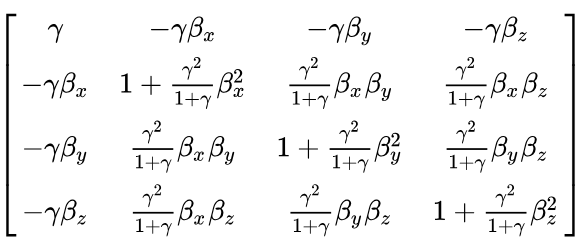



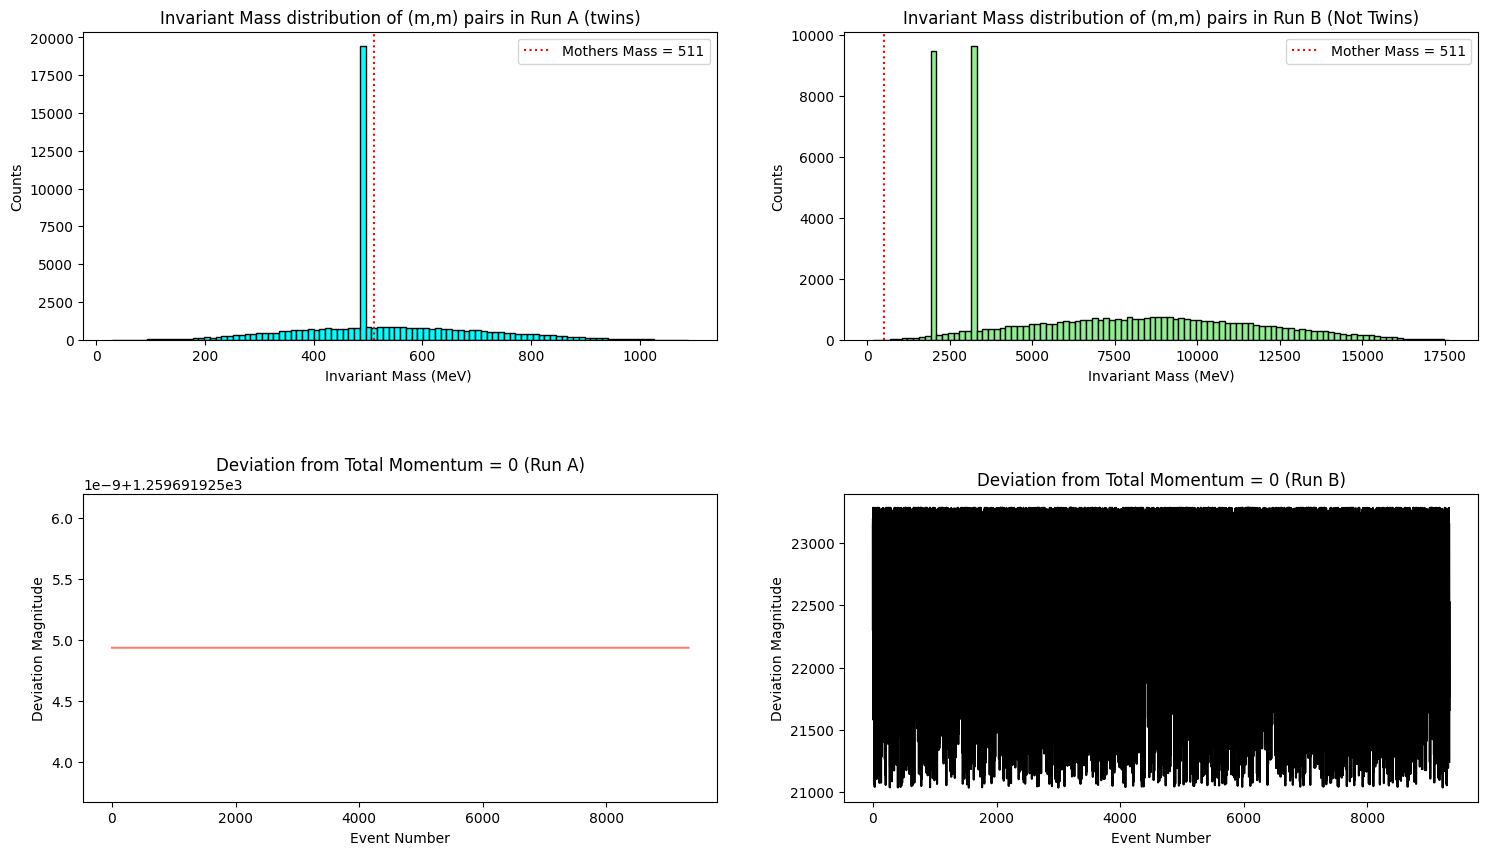

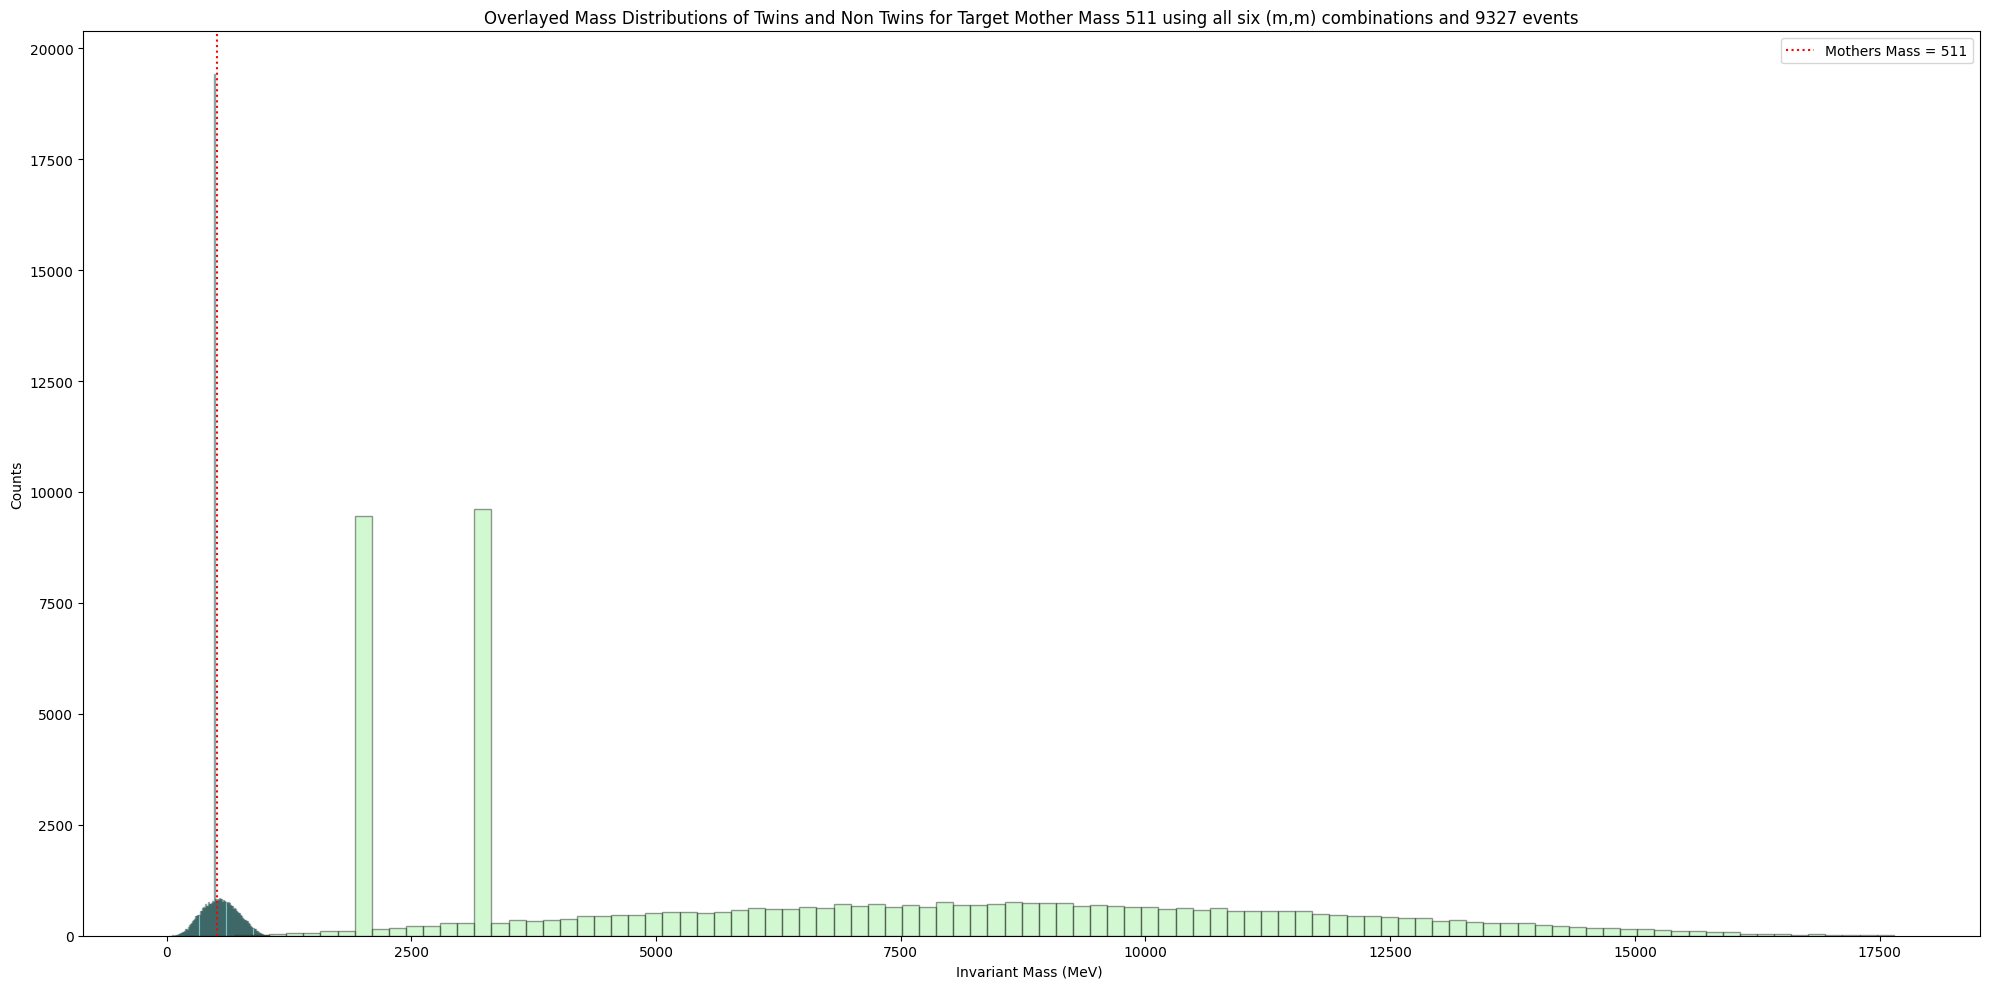

In [65]:
counts = 9327
moth_mass_targ = 511
uncert = 0.2
twin = True
minum = 0.1
inva, resida = run1(moth_mass_targ,uncert,twin,minum,counts)
invb, residb = run1(moth_mass_targ,uncert,not (twin),minum,counts)

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.hist(inva,bins=100,color='aqua',edgecolor='black')
plt.axvline(moth_mass_targ,color='red',linestyle=':',label=f'Mothers Mass = {moth_mass_targ}')
plt.title("Invariant Mass distribution of (m,m) pairs in Run A (twins)")
plt.xlabel("Invariant Mass (MeV) ")
plt.ylabel("Counts")
plt.legend()
plt.subplot(2,2,2)
plt.hist(invb,bins=100,color='lightgreen',edgecolor='black')
plt.axvline(moth_mass_targ,color='red',linestyle=':',label=f'Mother Mass = {moth_mass_targ}')
plt.title("Invariant Mass distribution of (m,m) pairs in Run B (Not Twins)")
plt.xlabel("Invariant Mass (MeV)")
plt.ylabel("Counts")
plt.legend()
plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing between rows

plt.subplot(2, 2, 3)
plt.plot(resida, color='salmon')
plt.title("Deviation from Total Momentum = 0 (Run A)")
plt.xlabel("Event Number")
plt.ylabel("Deviation Magnitude")
plt.subplot(2, 2, 4)
plt.plot(residb, color='black')
plt.title("Deviation from Total Momentum = 0 (Run B)")
plt.xlabel("Event Number")
plt.ylabel("Deviation Magnitude")

plt.figure(figsize=(20,10))
plt.hist(inva,bins=100,color='aqua',edgecolor='black', alpha=0.35)
plt.axvline(moth_mass_targ,color='red',linestyle=':',label=f'Mothers Mass = {moth_mass_targ}')
plt.title(f"Overlayed Mass Distributions of Twins and Non Twins for Target Mother Mass {moth_mass_targ} using all six (m,m) combinations and {counts} events")
plt.xlabel("Invariant Mass (MeV) ")
plt.ylabel("Counts")
plt.legend()
plt.hist(invb,bins=100,color='lightgreen',edgecolor='black', alpha =0.4)
plt.xlabel("Invariant Mass (MeV) ")
plt.ylabel("Counts")
plt.legend()

plt.tight_layout()
plt.show()
